# Famine Alert Price Model Walkthrough


## Method
We illustrate the process of identifying price anomolies as a means of
This is based on Baquedano:
"[Developing an indicator of price anomalies as an early warning tool: A compound growth approach](https://www.fao.org/3/i7550e/i7550e.pdf)"
Felix G. Baquedano. FAO, Rome, 2015.

## Data
As an illustration, we use food price data on Sudan from the FAO Food price monitoring tool:
1. [FAO data](https://fpma.fao.org/giews/fpmat4/#/dashboard/tool/domestic) (FAO. 2025. Food Price Monitoring and Analysis Tool. Accessed on February 3, 2025. Licence: CC-BY-4.0.)
2. We use [IMF CPI inflation data](https://www.imf.org/external/datamapper/PCPIPCH@WEO/WEOWORLD/SDN?year=2025) (Source: International Monetary Fund, "Inflation rate, average consumer prices")


In [1]:

import numpy as np
import pandas as pd
from pathlib import Path
import os

import json


try: # identify if in colab to fix paths
    import google.colab
    IN_COLAB = True
    print("colab identified.")
except ImportError:
    IN_COLAB = False

In [ ]:
# clone the repository to access the data

!git clone https://github.com/aristotle-tek/famine-prediction.git


In [ ]:
if IN_COLAB: # fix for paths in colab
    base_path = Path('/content/famine-prediction')
else:
    try:
        base_path = Path(__file__).resolve().parent.parent
    except NameError:
        base_path = Path.cwd().parent# .parent
print("Base path: ", base_path)

In [3]:
os.chdir(base_path)
from src.price_models import (
    compute_cgr, compute_volatility, adjust_cgr_for_volatility,
    weighted_mean, weighted_std, classify_anomaly, compute_anomaly_score,
    compute_gamma, combine_signals, handle_missing_data
)

In [4]:

# example - wheat - Sudan
sudan_wheat_file = base_path / 'data'/ 'raw'/ 'price_data' / 'Sudan_Wheat_Mon_Feb_03_2025.xlsx'

df = pd.read_excel(sudan_wheat_file, parse_dates=['Date'])
df.sort_values(by='Date', inplace=True)
df.set_index('Date', inplace=True)

# just rename to the region, since they are all for Wheat, Retail, SDG/Kg
df.columns =  df.columns.str.extract(r'RETAIL, ([^,]+), Wheat Grain')[0].str.replace(" ", "_")


In [5]:
# For now we will just use a single region & food as an example: Wheat prices in Al-Fashir

curr_var = 'Al-Fashir'
price_series = df[curr_var]

missing = df[curr_var].isna().sum()
total = len(df)
print(f"Missing values for {curr_var}: {missing}/{total} ({missing/total:.2%})")


Missing values for Al-Fashir: 12/182 (6.59%)


In [6]:
# Some price data is missing, so we will interpolate it

# print dates for which the price is missing
print(df[df[curr_var].isna()].index)

# Impute missing data using time-based interpolation (options include 'ffill', 'bfill', 'drop')
price_series = handle_missing_data(price_series, method='interpolate')

DatetimeIndex(['2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2011-05-01', '2011-06-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2024-02-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [7]:
# Now let's adjust for inflation

inflation_index = pd.read_excel(base_path /'data'/ 'raw'/ 'price_data' / 'Sudan_IMF-inflation-20250203.xlsx', index_col=0)

# The data is in rows, so transpose to get a column and set date as the index
inflation_index = inflation_index.T
inflation_index.drop(columns=['Inflation rate, average consumer prices (Annual percent change)'], inplace=True)



inflation_index['Date'] = pd.to_datetime(inflation_index.index.astype(str) + '-01-01')

# Set Date as index for easier merging
inflation_index.set_index('Date', inplace=True)

def adjust_for_inflation(price_series, inflation_series):
    """Adjusts price data for inflation using CPI index.
    Forward-fill (ffill) annual CPI values to align with the monthly price_series."""
    return price_series / inflation_series.reindex(price_series.index, method='ffill')

price_series = adjust_for_inflation(price_series, inflation_index['Sudan'])

print(price_series.tail())

Date
2024-06-01    14.992504
2024-07-01    13.328336
2024-08-01    17.769465
2024-09-01    20.572214
2024-10-01    21.239380
dtype: float64


In [8]:

# 1. Calc Compound Growth Rates (CGRs)
# Quarterly (3-month) and annual
# NB: If the window for refers to the duration of the growth period ($t_n - t_0$),
# then the number of data points needed is duration + 1.
cqgr = compute_cgr(price_series, window=4)
cagr = compute_cgr(price_series, window=13)

# 2. Calc Volatility
# Volatility is the std dev of log differences over the same period as CGR.
# The 'window' parameter in compute_volatility refers to this CGR period length.
vol_q = compute_volatility(price_series, window=4)
vol_a = compute_volatility(price_series, window=13)

# 3. Adjust CGRs for Volatility (vCGRs)
# Deflate CGR by (1 - volatility). Using clip=True to ensure (1 - vol) >= 0.
# This prevents negative CGRs if volatility > 100%, aligning with reducing Type I error.
vcqgr = adjust_cgr_for_volatility(cqgr, vol_q, clip=True)
vcagr = adjust_cgr_for_volatility(cagr, vol_a, clip=True)

df_analysis = pd.DataFrame(index=price_series.index)
df_analysis['price_original'] = df[curr_var] # Keep original prices for ref
df_analysis['price_real'] = price_series
df_analysis['cqgr'] = cqgr
df_analysis['cagr'] = cagr
df_analysis['vol_q'] = vol_q
df_analysis['vol_a'] = vol_a
df_analysis['vcqgr'] = vcqgr
df_analysis['vcagr'] = vcagr

print("\nDataFrame with CGRs and vCGRs (head with NaNs from rolling operations):")
print(df_analysis.head(15))
print("\nDataFrame with CGRs and vCGRs (tail):")
print(df_analysis.tail())

# 4. Calc historical weighted means and st devs for each month
# These are vCXGR}_Wt and \hat{\sigma}_{vCXGR,Wt} from Eq. 4 & 5.
# They are calculated for each month (e.g., all Januaries, all Feb etc) across the years.

monthly_historical_stats = {}

for month_num in range(1, 13):
    # Filter vCGR data for the current calendar month across all available years
    vcqgr_for_month_m = df_analysis['vcqgr'][df_analysis.index.month == month_num].dropna()
    vcagr_for_month_m = df_analysis['vcagr'][df_analysis.index.month == month_num].dropna()

    # Define weights: increasing time weights.
    # simple approach: chronological sequence 1, 2, ..., N for observations in that month.
    # This assumes vcqgr_for_month_m and vcagr_for_month_m are time-sorted (which they should be from df_analysis).
    weights_q_m = np.arange(1, len(vcqgr_for_month_m) + 1)
    weights_a_m = np.arange(1, len(vcagr_for_month_m) + 1)
    
    current_month_stats = {
        'mean_vcqgr': np.nan, 'std_vcqgr': np.nan,
        'mean_vcagr': np.nan, 'std_vcagr': np.nan
    }

    if len(vcqgr_for_month_m) > 0: # Need at least 1 point for mean
        current_month_stats['mean_vcqgr'] = weighted_mean(vcqgr_for_month_m.values, weights_q_m)
        if len(vcqgr_for_month_m) > 1: # Need at least 2 points for std dev
            current_month_stats['std_vcqgr'] = weighted_std(vcqgr_for_month_m.values, weights_q_m)

    if len(vcagr_for_month_m) > 0:
        current_month_stats['mean_vcagr'] = weighted_mean(vcagr_for_month_m.values, weights_a_m)
        if len(vcagr_for_month_m) > 1:
            current_month_stats['std_vcagr'] = weighted_std(vcagr_for_month_m.values, weights_a_m)
            
    monthly_historical_stats[month_num] = current_month_stats

# print("\nMonthly historical weighted stats (example for January):")
# print(f"January (Month 1): {monthly_historical_stats[1]}")


# 5. Calc anomaly scores (X_IPA_t^Z)
# Using Equation (6): (vCGR_t - historical_weighted_mean_for_month_t) / historical_weighted_std_for_month_t

ipa_q_values = []
for date_index, vcqgr_current_value in df_analysis['vcqgr'].items():
    month_of_date = date_index.month
    hist_mean = monthly_historical_stats[month_of_date]['mean_vcqgr']
    hist_std = monthly_historical_stats[month_of_date]['std_vcqgr']
    score = compute_anomaly_score(vcqgr_current_value, hist_mean, hist_std)
    ipa_q_values.append(score)
df_analysis['ipa_quarterly'] = ipa_q_values

ipa_a_values = []
for date_index, vcagr_current_value in df_analysis['vcagr'].items():
    month_of_date = date_index.month
    hist_mean = monthly_historical_stats[month_of_date]['mean_vcagr']
    hist_std = monthly_historical_stats[month_of_date]['std_vcagr']
    score = compute_anomaly_score(vcagr_current_value, hist_mean, hist_std)
    ipa_a_values.append(score)
df_analysis['ipa_annual'] = ipa_a_values

# 6. Compute gamma (γ)
# Gamma is the weight for the quarterly IPA score, derived from PCA on vCQGR and vCAGR series.
# The compute_gamma function handles NaNs by aligning and dropping them before PCA.
gamma_weight = compute_gamma(df_analysis['vcqgr'], df_analysis['vcagr'])
print(f"\nComputed Gamma (γ) for combining signals: {gamma_weight:.4f}")
if gamma_weight == 0.5:
    print("Note: Gamma is 0.5. This might occur if series have insufficient common data points or no variability for PCA.")

# 7. Combine quarterly and annual anomaly scores into final IPA_t
# Eq (7): IPA_t = γ * IPA_quarterly + (1-γ) * IPA_annual
# The combine_signals function takes float vals.
# Apply it row-wise or ensure pd series alignment handles NaNs appropriately.
# If ipa_quarterly or ipa_annual is NaN, the result for that row might be NaN.
df_analysis['ipa_final'] = combine_signals(df_analysis['ipa_quarterly'], 
                                           df_analysis['ipa_annual'], 
                                           gamma_weight)

# 8. Classify anomalies
# Based on the thresholds: Normal, Price Watch (0.5 <= score < 1), Price Alert (score >= 1)
df_analysis['classification'] = df_analysis['ipa_final'].apply(classify_anomaly)


print("\nFinal DataFrame with IPA calculations (showing last 24 months):")
display_cols = ['price_real', 'vcqgr', 'vcagr', 'ipa_quarterly', 'ipa_annual', 'ipa_final', 'classification']
print(df_analysis[display_cols].tail(24))

print("\nSummary of classifications:")
print(df_analysis['classification'].value_counts(dropna=False)) # include NaNs



DataFrame with CGRs and vCGRs (head with NaNs from rolling operations):
            price_original  price_real      cqgr      cagr     vol_q  \
Date                                                                   
2009-09-01            2.37    0.209735       NaN       NaN       NaN   
2009-10-01            2.07    0.183186       NaN       NaN       NaN   
2009-11-01            2.45    0.216814       NaN       NaN       NaN   
2009-12-01            4.54    0.401770  0.241945       NaN  0.378394   
2010-01-01            5.20    0.400000  0.297347       NaN  0.320635   
2010-02-01            2.70    0.207692 -0.014225       NaN  0.636181   
2010-03-01            2.62    0.201538 -0.205440       NaN  0.368666   
2010-04-01            2.80    0.215385 -0.186449       NaN  0.391881   
2010-05-01             NaN    0.210860  0.005058       NaN  0.053358   
2010-06-01             NaN    0.206184  0.007625       NaN  0.050968   
2010-07-01             NaN    0.201659 -0.021710       NaN  0.0

In [9]:
#Print alerts/watches for verification
print("\nPrice Alerts:")
print(df_analysis[df_analysis['classification'] == 'Price Alert'][display_cols])
print("\nPrice Watches:")
print(df_analysis[df_analysis['classification'] == 'Price Watch'][display_cols])


Price Alerts:
            price_real     vcqgr     vcagr  ipa_quarterly  ipa_annual  \
Date                                                                    
2015-01-01    0.372781  0.139002  0.068269       1.084887    0.673399   
2018-08-01    0.442338  0.160499  0.030116       1.981610   -0.054581   
2018-09-01    0.442338  0.132649  0.032734       2.199147    0.033165   
2019-01-01    0.686275  0.132819  0.080457       1.032294    0.881951   
2019-02-01    0.686275  0.178615  0.073942       1.389110    0.950877   
2020-04-01    0.614391  0.340373 -0.007037       2.641256   -0.735020   
2020-05-01    0.722596  0.257582 -0.002869       2.100867   -0.649670   
2020-11-01    1.047152  0.128604  0.014755       1.761835   -0.491119   
2022-01-01    3.494236  0.181016  0.127391       1.442276    1.685038   
2022-02-01    3.607709  0.186654  0.109640       1.460745    1.686277   
2022-03-01    4.559078  0.258688  0.120345       1.986466    1.995141   
2022-05-01    5.792507  0.154694  0.

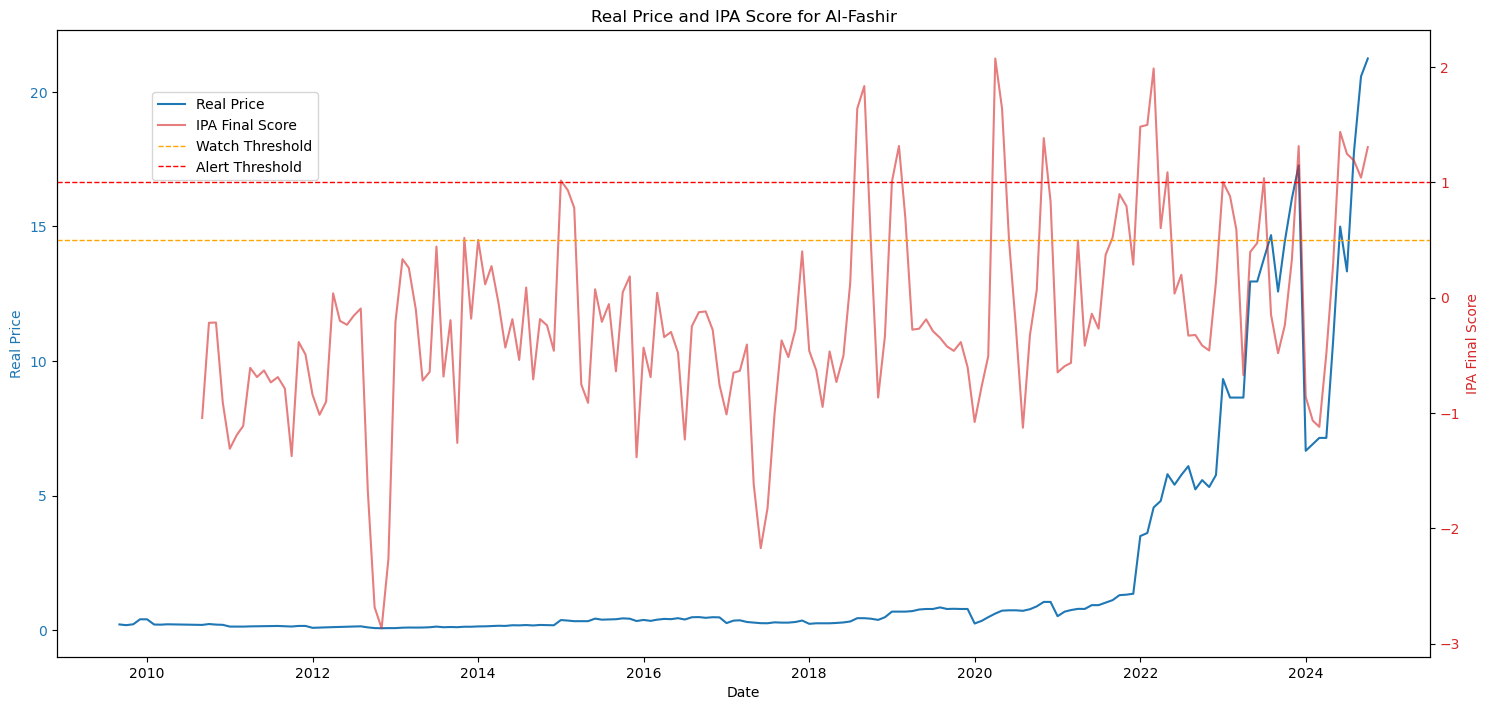

In [10]:
# plot price_real and highlight periods of 'Price Watch' or 'Alert'
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 7))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Real Price', color=color)
ax1.plot(df_analysis.index, df_analysis['price_real'], color=color, label='Real Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # second axis that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('IPA Final Score', color=color) # we already handled the x-label with ax1
ax2.plot(df_analysis.index, df_analysis['ipa_final'], color=color, alpha=0.6, label='IPA Final Score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0.5, color='orange', linestyle='--', lw=1, label='Watch Threshold')
ax2.axhline(1.0, color='red', linestyle='--', lw=1, label='Alert Threshold')

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title(f'Real Price and IPA Score for {curr_var}')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()



In [11]:
# test stationarity
# First, we will need to import arch and statsmodels
!pip install arch statsmodels


In [12]:
import importlib
import src.stationarity_tests as stationarity_tests
importlib.reload(stationarity_tests)

adf_result = stationarity_tests.test_adf(price_series)
pp_result = stationarity_tests.test_pp(price_series)
dfgls_result = stationarity_tests.test_dfgls(price_series)
kpss_result = stationarity_tests.test_kpss(price_series)

print("ADF Test:", adf_result)
print("\n\nPhillips-Perron Test:", pp_result)
print("\n\nDF-GLS Test:", dfgls_result)
print("\n\nKPSS Test:", kpss_result)

ADF Test: {'Test Statistic': -0.7530797085497211, 'p-value': 0.9694163425476943, 'Lags Used': 10, 'Number of Observations': 171, 'Critical Values': {'1%': -4.012711131704242, '5%': -3.4364829463776627, '10%': -3.1423091729829}, 'IC Best': 466.4332134745893}


Phillips-Perron Test: {'Test Statistic': 1.348496576023351, 'p-value': 1.0, 'Critical Values': {'1%': -4.0096774902428285, '5%': -3.435029821283931, '10%': -3.1414586641558206}}


DF-GLS Test: {'Test Statistic': -1.242360205075232, 'p-value': 0.7249107068143679, 'Critical Values': {'1%': -3.533021251090802, '5%': -2.959185360072051, '10%': -2.6686933331478673}}


KPSS Test: {'Test Statistic': 0.3872056166493753, 'p-value': 0.01, 'Lags Used': 8, 'Critical Values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}}


/Users/andrew/Dropbox/00_code/_Elenchos/_faminepred/famine-prediction/src/stationarity_tests.py:171: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series_clean, regression=regression, **kwargs)


In [13]:
# To simplify the interpretation of the tests, we can re-organize the output

def summarize_stationarity_tests(adf_result, pp_result, dfgls_result, kpss_result):
    summary = {}

    adf_stat = adf_result['Test Statistic']
    adf_pval = adf_result['p-value']
    adf_critical = adf_result['Critical Values']
    if adf_stat < adf_critical['10%'] and adf_pval < 0.05:
        summary['ADF Test'] = "Suggests Stationarity"
    else:
        summary['ADF Test'] = "Suggests Non-Stationarity"

    pp_stat = pp_result['Test Statistic']
    pp_pval = pp_result['p-value']
    pp_critical = pp_result['Critical Values']
    if pp_stat < pp_critical['10%'] and pp_pval < 0.05:
        summary['Phillips-Perron Test'] = "Suggests Stationarity"
    else:
        summary['Phillips-Perron Test'] = "Suggests Non-Stationarity"

    dfgls_stat = dfgls_result['Test Statistic']
    dfgls_pval = dfgls_result['p-value']
    dfgls_critical = dfgls_result['Critical Values']
    if dfgls_stat < dfgls_critical['10%'] and dfgls_pval < 0.05:
        summary['DF-GLS Test'] = "Suggests Stationarity"
    else:
        summary['DF-GLS Test'] = "Suggests Non-Stationarity"

    # KPSS (opposite null hypothesis)
    kpss_stat = kpss_result['Test Statistic']
    kpss_critical = kpss_result['Critical Values']
    if kpss_stat < kpss_critical['1%']:
        summary['KPSS Test'] = "Suggests Stationarity"
    else:
        summary['KPSS Test'] = "Suggests Non-Stationarity"

    return summary

summary_results = summarize_stationarity_tests(adf_result, pp_result, dfgls_result, kpss_result)
for test, result in summary_results.items():
    print(f"{test}: {result}")


ADF Test: Suggests Non-Stationarity
Phillips-Perron Test: Suggests Non-Stationarity
DF-GLS Test: Suggests Non-Stationarity
KPSS Test: Suggests Non-Stationarity


## Interpretation

The fact that the series is non-stationary suggests the importance of using Baquedano's approach which is more reliable with non-stationary data.